# Projet: Prédiction des All-Stars de NBA
# Livio ALLARAJ, Jessee KINGUE

Dans ce projet, nous essayons de prédire les joueurs de NBA qui seront choisis pour le match des All-Stars d'une année donnée. 
Le match des All-Stars n'est pas forcément un match très sérieux, sachant qu'il n'y a pas de conséquences directes sur le championnat, et c'est plutôt un match de "show". Néanmoins, le processus de séléction des joueurs pour ce match est bien directement dépendant de la performance de chaque joueur pendant la saison.

Ici nous 'prédisons' les joueurs pour l'année 2023, afin de vraiment tester la précision du modèle, sachant que ce match a déjà eu lieu. Pour faire cette prédiction, nous utiliserons la bibliothéque TensorFlow afin de créer un réseau de neurones, qu'on entraîne avec des données obtenues sur Kaggle.

Nous essayons ensuite de faire la même prédiction avec un modèle Random Forest.

Dans un premier pas, nous importons les bibliothéques nécessaires, comme:

* Numpy: Bibliothéque des tableaux, une unique usage dans la prédiction préliminaire.
* Pandas: La bibliothéque de base pour l'importation et la manipulation des jeux de données.
* Matplotlib: L'affichage des graphiques de l'évolution du modèle.
* Tensorflow: La bilbiothéque de base pour l'implémentation du réseau des neurones.
* Seaborn: Bibliothéque d'affichage des graphiques sur l'exploration des données.
* Scikit-learn: Bibliothéque diverse, utilisée pour la séparation du jeu de données en données d'entraînement et validation/test.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import tensorflow.keras.models as km
import tensorflow.keras.layers as kl
import seaborn as sns
from sklearn.model_selection import train_test_split
# Random Forest
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
# Optional for after
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


Nous importons le fichier ***playerdata.csv***, qui contient toutes les statistiques de tous les joueurs pour 2010-2023. Nous avons aussi accès à une autre base de données, qui contient quelques statistiques de tous les joueurs pour 1980-2022, qui ont été choisis pour le match des All-Stars de chaque année. Ce que nous avons choisi de faire, c'est éventuellement combiner ces deux bases de données sur l'intervalle de temps en commun, qui est 2010-2022.

On doit aussi noter que les deux fichiers CSV (Comma Separated Values) n'ont pas forcément la même méthode d'encodage (plus spécifiquement, une liste contient des accents, mais pas l'autre), donc la méthode plus facile d'éviter les problèmes lors de la combinaison des deux DataFrames est simplement d'enlever les accents des noms des joueurs qui ont été choisis All-Stars (Heureusement, il n'y a que 4 joueurs à modifier).

In [3]:
pdata = pd.read_csv("playerdata.csv", encoding="utf-8") # The dataframe containing all player data per year
pdata = pdata[pdata['Year'] <= 2022] # The common time interval between the two datasets is 2010-2022 (playerdata.csv is 2010-2023)
pdata = pdata.sort_values('Year') # Sorting dataframe by year, to be coherent with the next one containing All-Stars

# Replacing a few player names (only actual present all-stars in the next dataframe) 
# for the total player data to avoid mismatches during the merge of the 2 dataframes after
pdata.loc[pdata['Name'] == 'Nikola Jokić', 'Name'] = 'Nikola Jokic'
pdata.loc[pdata['Name'] == 'Luka Dončić', 'Name'] = 'Luka Doncic'
pdata.loc[pdata['Name'] == 'Goran Dragić', 'Name'] = 'Goran Dragic'
pdata.loc[pdata['Name'] == 'Nikola Vučević', 'Name'] = 'Nikola Vucevic'
pdata

,Unnamed: 0,Year,Name,Position,Age,Team,Games Played,Games Started,MPG,FG,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
7059,7059,2010,Thaddeus Young,PF,21,PHI,67,45,32.0,5.7,...,0.691,1.9,3.3,5.2,1.4,1.2,0.2,1.9,2.0,13.8
6757,6757,2010,Jeff Foster,C,33,IND,16,3,15.9,1.4,...,0.556,2.1,2.9,5.1,1.3,0.2,0.3,0.9,2.8,3.1
6758,6758,2010,Randy Foye,PG,26,WAS,70,38,23.8,3.7,...,0.890,0.2,1.6,1.9,3.3,0.5,0.1,1.3,1.8,10.1
6759,6759,2010,Channing Frye,C,26,PHO,81,41,27.0,3.9,...,0.810,0.8,4.5,5.3,1.4,0.8,0.9,0.9,3.2,11.2
6760,6760,2010,Dan Gadzuric,C,31,MIL,32,6,9.8,1.2,...,0.400,1.2,1.7,2.9,0.4,0.3,0.4,0.5,2.0,2.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
940,940,2022,Svi Mykhailiuk,SF,24,TOR,56,5,12.8,1.6,...,0.865,0.4,1.3,1.6,0.8,0.5,0.1,0.6,1.0,4.6
939,939,2022,Mike Muscala,C,30,OKC,43,0,13.8,2.6,...,0.842,0.5,2.5,3.0,0.5,0.4,0.6,0.3,1.3,8.0
938,938,2022,Dejounte Murray,PG,25,SAS,68,68,34.8,8.4,...,0.794,1.2,7.1,8.3,9.2,2.0,0.3,2.6,2.0,21.1
936,936,2022,Ade Murkey,SG,24,SAC,1,0,1.0,0.0,...,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Ici, on importe le deuxième ci-dessus mentionné, ***final_data.csv***, contenant particulièrement des valeurs 0 et 1, précisant si un joueur a été choisi ou pas. Pour avoir une cohérence entre les deux DataFrames, on combine les prénoms et noms ici dans une seule colonne.

In [4]:
asdata = pd.read_csv("final_data.csv", encoding="utf-8") # The dataframe containing all-stars per year (and some unnecessary data, not to be used anyway)
asdata = asdata[asdata['year'] >= 2010] # Same thing as previously, 2010-2022

# This dataframe contains separate columns for first and last name, combining the two here
asdata['name'] = asdata['first'] + ' ' + asdata['last']
asdata.insert(0, 'name', asdata.pop('name'))

# Renaming the two common columns to prepare for the merging
asdata.rename(columns={'name': 'Name', 'year': 'Year'}, inplace=True)
asdata.drop(columns=['first', 'last'], inplace=True)
asdata

,Name,team,Year,games_played,min,fgm,fga,fg3m,fg3a,ftm,...,reb,ast,stl,blk,turnover,pf,pts,fg_pct,fg3_pct,ft_pct
693,Kevin Durant,OKC,2010,78.0,38:56:00,9.12,19.72,1.86,5.31,7.62,...,6.83,2.74,1.13,0.97,2.79,2.04,27.71,0.462,0.350,0.880
694,Kobe Bryant,LAL,2010,82.0,33:53:00,9.02,19.99,1.40,4.34,5.89,...,5.11,4.73,1.21,0.15,2.96,2.10,25.34,0.451,0.323,0.828
695,Chris Paul,NOH,2010,80.0,36:00:00,5.38,11.60,0.89,2.29,4.21,...,4.09,9.78,2.35,0.06,2.21,2.45,15.85,0.463,0.388,0.878
696,Carmelo Anthony,DEN,2010,77.0,35:43:00,8.88,19.52,1.23,3.26,6.58,...,7.31,2.87,0.88,0.60,2.68,2.91,25.58,0.455,0.378,0.838
697,Tim Duncan,SAS,2010,76.0,28:21:00,5.51,11.03,0.00,0.05,2.42,...,8.92,2.67,0.66,1.92,1.61,1.57,13.45,0.500,0.000,0.716
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
998,Paul George,LAC,2022,56.0,34:39:00,8.20,17.93,2.82,7.61,4.57,...,6.11,5.14,1.48,0.36,3.14,2.84,23.79,0.457,0.371,0.871
999,Anthony Edwards,MIN,2022,81.0,36:10:00,8.86,19.47,2.67,7.35,3.98,...,5.88,4.46,1.58,0.77,3.27,2.36,24.37,0.455,0.363,0.756
1000,Tyrese Haliburton,IND,2022,56.0,33:32:00,7.36,15.02,2.88,7.18,3.13,...,3.66,10.45,1.63,0.45,2.52,1.23,20.71,0.490,0.400,0.871
1001,De'Aaron Fox,SAC,2022,73.0,33:23:00,9.34,18.23,1.63,5.03,4.70,...,4.19,6.12,1.14,0.32,2.48,2.36,25.01,0.512,0.324,0.780


Avec les deux DataFrames étant prêts pour la combinaison/fusion, nous créons une colonne contenant des 1, et on fusionne les DataFrames sur la condition que si le joueur et l'année sont les mêmes pour les deux DataFrames, on rajoute une colonne au DataFrame ***pdata*** contenant des 1. On remplace ensuite toutes les cellules contenant NaN avec 0 (les joueurs qui n'ont pas été choisis).

In [5]:
# Code merges the 2 dataframes, based on if each player is present in that year's All-Star roster
asdata['AS'] = 1
pdata = pd.merge(pdata, asdata[['Name', 'Year', 'AS']], on=['Name', 'Year'], how='left')
pdata['AS'].fillna(0, inplace=True)
# Cell to be run only once, or restart kernel (code will keep trying to merge DataFrames, but it only works once)

Nous faisons ici quelques simples affichages, pour voir si la fusion a été réussie, et de voir la liste de toutes les statistiques des joueurs (qui seront ensuite nos features).

In [6]:
pdata.head(20)

,Unnamed: 0,Year,Name,Position,Age,Team,Games Played,Games Started,MPG,FG,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,AS
0,7059,2010,Thaddeus Young,PF,21,PHI,67,45,32.0,5.7,...,1.9,3.3,5.2,1.4,1.2,0.2,1.9,2.0,13.8,0.0
1,6757,2010,Jeff Foster,C,33,IND,16,3,15.9,1.4,...,2.1,2.9,5.1,1.3,0.2,0.3,0.9,2.8,3.1,0.0
2,6758,2010,Randy Foye,PG,26,WAS,70,38,23.8,3.7,...,0.2,1.6,1.9,3.3,0.5,0.1,1.3,1.8,10.1,0.0
3,6759,2010,Channing Frye,C,26,PHO,81,41,27.0,3.9,...,0.8,4.5,5.3,1.4,0.8,0.9,0.9,3.2,11.2,0.0
4,6760,2010,Dan Gadzuric,C,31,MIL,32,6,9.8,1.2,...,1.2,1.7,2.9,0.4,0.3,0.4,0.5,2.0,2.8,0.0
5,6761,2010,Sundiata Gaines,PG,23,UTA,32,0,6.8,1.2,...,0.2,0.7,0.9,1.2,0.4,0.0,0.4,0.5,3.3,0.0
6,6762,2010,Danilo Gallinari,SF,21,NYK,81,74,33.9,4.8,...,0.8,4.1,4.9,1.7,0.9,0.7,1.4,2.4,15.1,0.0
7,6763,2010,Francisco García,SG,28,SAC,25,4,23.0,3.3,...,0.4,2.2,2.6,1.8,0.4,0.8,0.8,2.0,8.1,0.0
8,6764,2010,Kevin Garnett,PF,33,BOS,69,69,29.9,5.8,...,1.1,6.2,7.3,2.7,1.0,0.8,1.5,2.5,14.3,1.0
9,6765,2010,Marc Gasol,C,25,MEM,69,69,35.8,5.5,...,3.0,6.3,9.3,2.4,1.0,1.6,2.0,3.7,14.6,0.0


In [7]:
pdata.columns

Index(['Unnamed: 0', 'Year', 'Name', 'Position', 'Age', 'Team', 'Games Played',
       'Games Started', 'MPG', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P',
       '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST',
       'STL', 'BLK', 'TOV', 'PF', 'PTS', 'AS'],
      dtype='object')

## Analyse éxploratoire des données

Nous faisons ici une éxploration des données plus concrète, en visualisant la distribution des joueurs en fonction des toutes les features.

On choisit d'abord seulement les colonnes contenant des valeurs numériques, et nous formons un DataFrame ***pl*** qui sera utile pour l'affichage.

Précisions sur la signification des features:

* MPG = Minutes Per Game
* FG = Field Goals (Tirs marqués par match)
* FGA = Field Goal Attempts (Tirs essayés)
* FG% = Field Goal Percentage (Pourcentage des tirs marqués sur les tirs essayés)
* 3P = Three Pointers (Tirs de 3 points marqués par match)
* 3PA = Three Pointer Attempts
* 3P% = Three Pointer Percentage
* 2P = Two Pointers
* 2PA = Two Pointer Attempts
* 2P% = Two Pointer Percentage
* eFG% = Effective Field Goal Percentage:
$eFG\% = \frac{FG + (0.5 * 3P)}{FGA}$
* FT = Free Throws (Tirs libres)
* FTA = Free Throw Attempts
* FT% = Free Throw Percentage
* ORB = Offensive Rebounds (Rebonds offensifs)
* DRB = Defensive Rebounds (Rebonds défensifs)
* TRB = Total Rebounds
* AST = Assists
* STL = Steals (Balles volées)
* BLK = Blocks (Tirs opposés bloqués)
* TOV = Turnovers (Balles perdues)
* PF = Personal Fouls (Fautes)
* PTS = Points per game
* AS = All-Star (Colonne ajoutée précédemment)

In [8]:
# Choosing the relevant stats for training (preliminary)
init_cols = ['Age', 'Games Played',
       'Games Started', 'MPG', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P',
       '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST',
       'STL', 'BLK', 'TOV', 'PF', 'PTS', 'AS']


# DataFrame containing all the (numerical) data, for visualisation purposes only
pl = pdata[init_cols]
pl

,Age,Games Played,Games Started,MPG,FG,FGA,FG%,3P,3PA,3P%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,AS
0,21,67,45,32.0,5.7,12.1,0.470,0.7,2.1,0.348,...,1.9,3.3,5.2,1.4,1.2,0.2,1.9,2.0,13.8,0.0
1,33,16,3,15.9,1.4,2.9,0.478,0.0,0.1,0.000,...,2.1,2.9,5.1,1.3,0.2,0.3,0.9,2.8,3.1,0.0
2,26,70,38,23.8,3.7,8.8,0.414,0.9,2.6,0.346,...,0.2,1.6,1.9,3.3,0.5,0.1,1.3,1.8,10.1,0.0
3,26,81,41,27.0,3.9,8.7,0.451,2.1,4.8,0.439,...,0.8,4.5,5.3,1.4,0.8,0.9,0.9,3.2,11.2,0.0
4,31,32,6,9.8,1.2,2.8,0.438,0.0,0.0,0.000,...,1.2,1.7,2.9,0.4,0.3,0.4,0.5,2.0,2.8,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6516,24,56,5,12.8,1.6,4.2,0.389,0.7,2.4,0.306,...,0.4,1.3,1.6,0.8,0.5,0.1,0.6,1.0,4.6,0.0
6517,30,43,0,13.8,2.6,5.8,0.456,1.6,3.8,0.429,...,0.5,2.5,3.0,0.5,0.4,0.6,0.3,1.3,8.0,0.0
6518,25,68,68,34.8,8.4,18.3,0.462,1.4,4.3,0.327,...,1.2,7.1,8.3,9.2,2.0,0.3,2.6,2.0,21.1,0.0
6519,24,1,0,1.0,0.0,0.0,0.000,0.0,0.0,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


On fait ici les visualisation des features pour les All-Stars et les non All-Stars, comparant la distribution des joueurs de chaque catégorie pour un feature donné.

Il faut préciser ici que l'apparition des valeurs négatives dans les graphes est simplement une conséquence visuelle, dûe au fonctionnement de la bibliothéque Seaborn, mais en réalité il n'y a aucune valeur négative présente dans notre jeu de données.

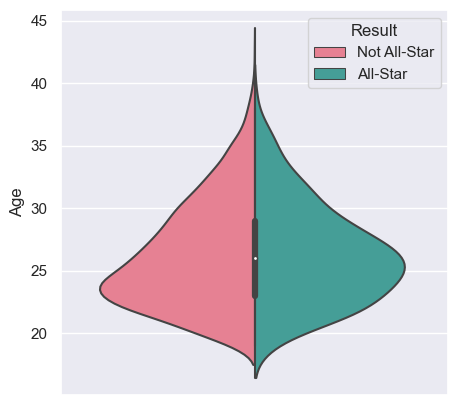

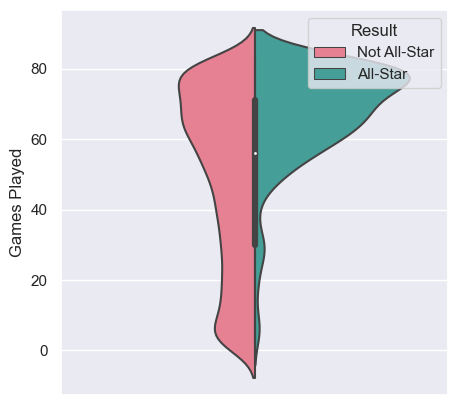

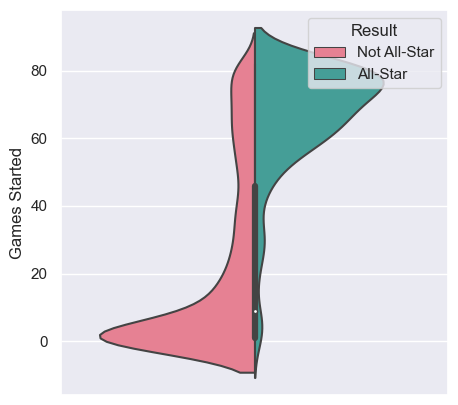

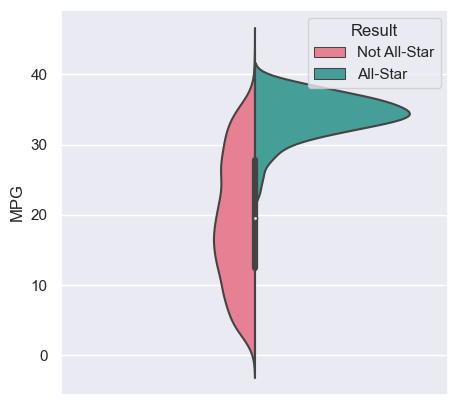

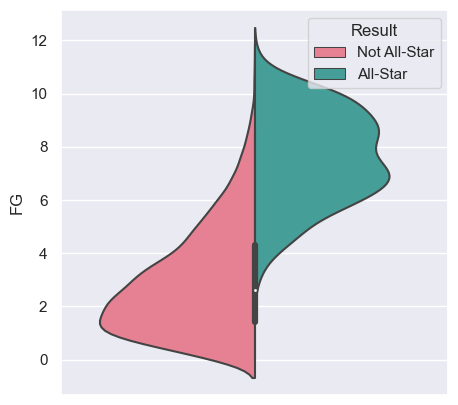

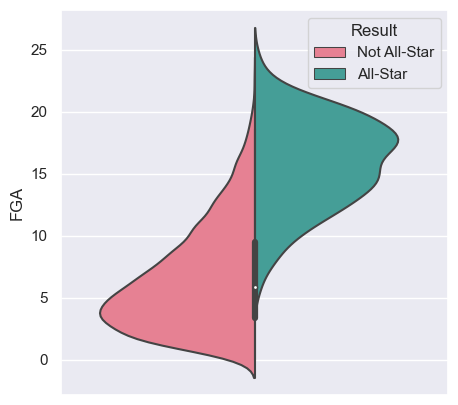

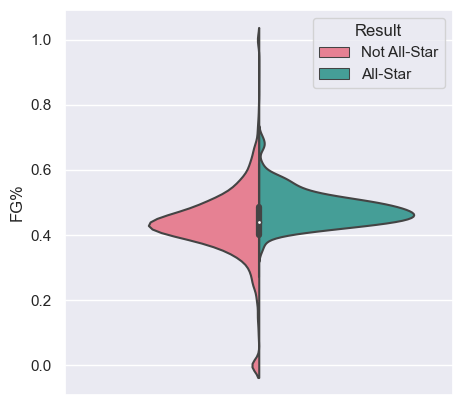

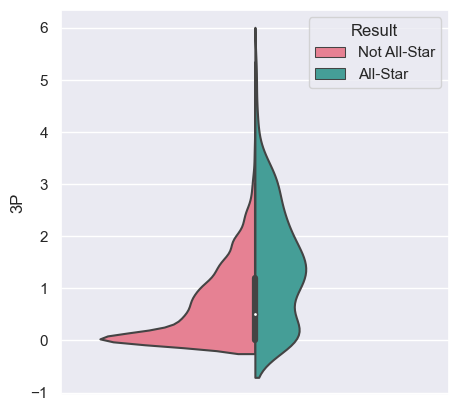

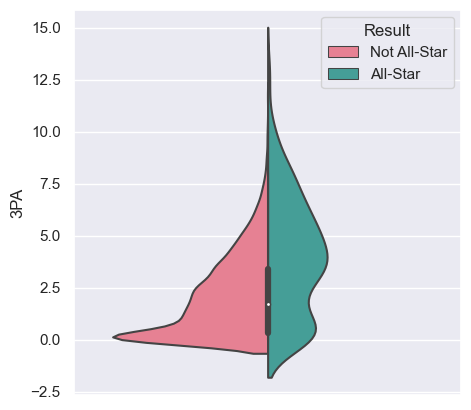

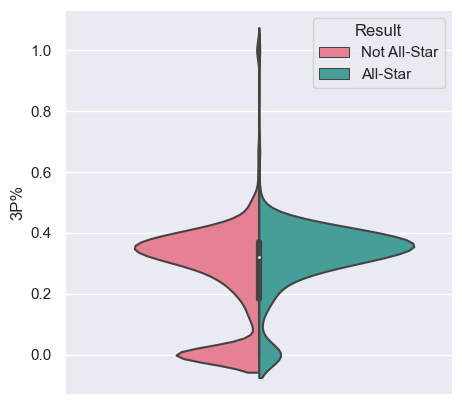

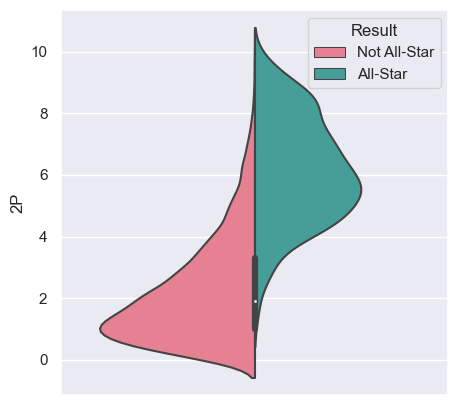

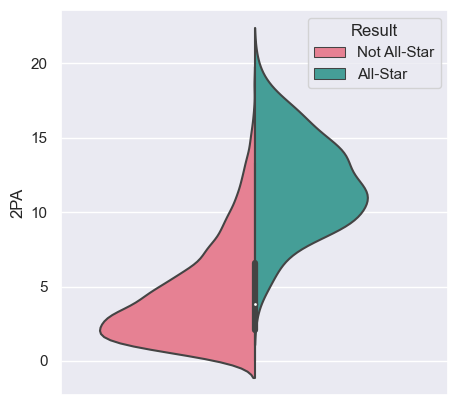

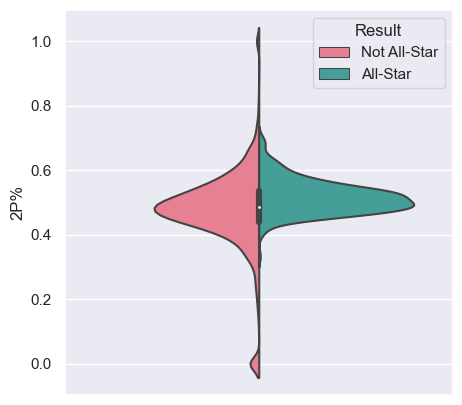

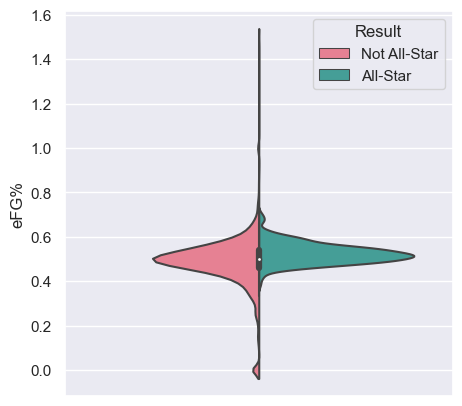

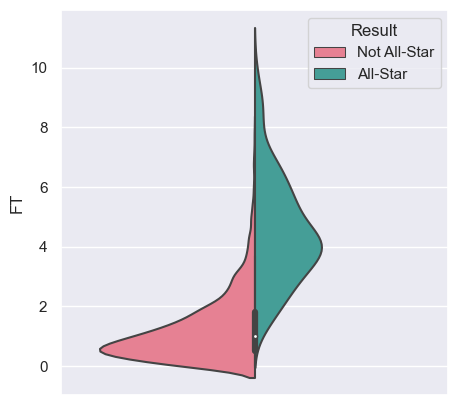

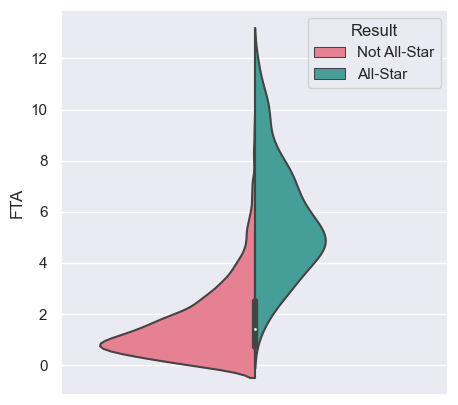

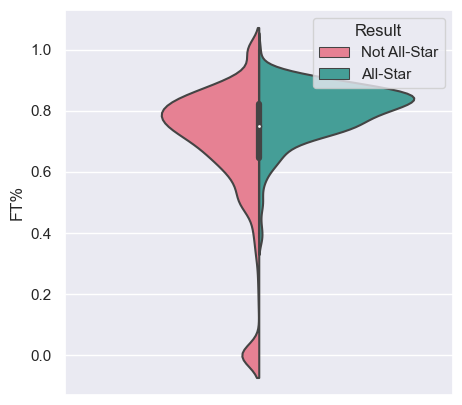

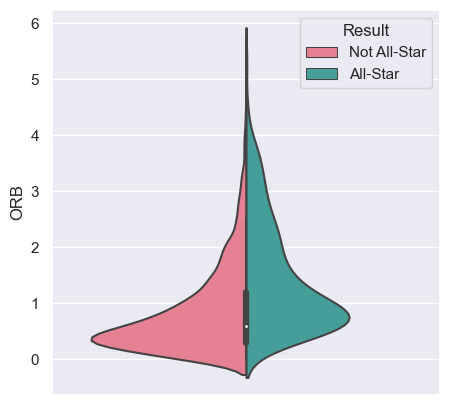

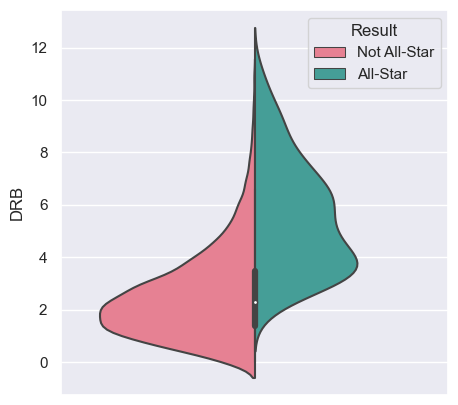

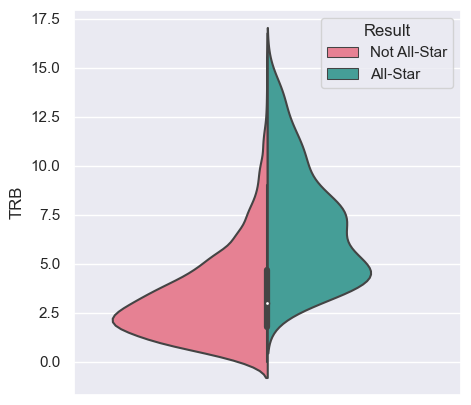

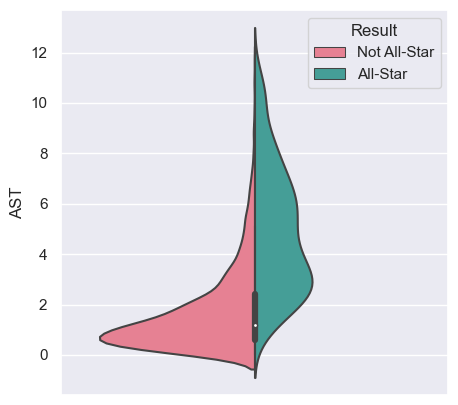

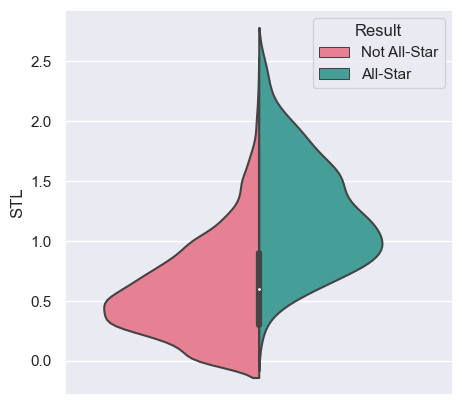

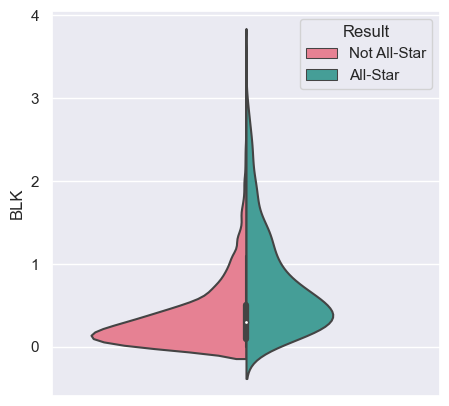

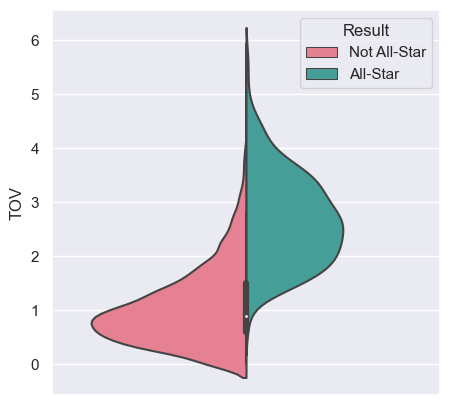

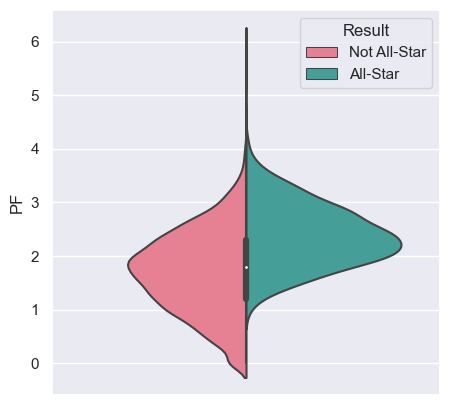

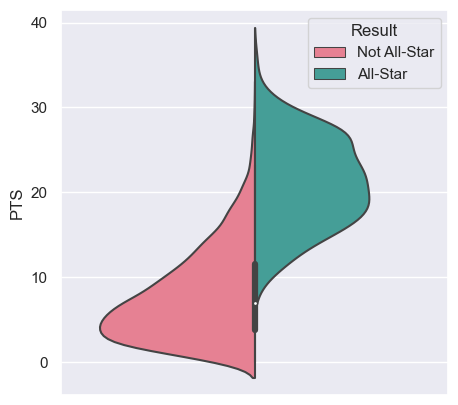

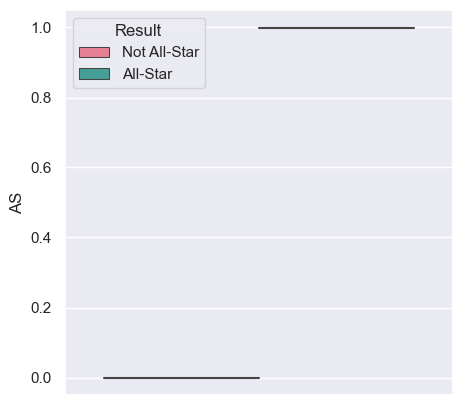

In [9]:
husl = sns.color_palette('husl')
# 0 = non all-star: red
# 1 = all-star: green
palette = {
    0 : husl[0],
    1 : husl[3]
}

plt.style.use('default')
sns.set(style='darkgrid')
plt.rcParams['legend.title_fontsize'] = 'medium'

for feat in init_cols:
    fig, ax = plt.subplots(figsize=(5,5))
    sns.violinplot(ax=ax, data=pl, y=feat, x=[''] * len(pl), hue='AS', split=True, palette=palette)
    ax.legend_.set_title('Result')
    new_labels = ['Not All-Star', 'All-Star']
    for t, l in zip(ax.legend_.texts, new_labels):
        t.set_text(l)
    # Optional line to save plots
    plt.savefig('{}-violinplot.png'.format(feat))
    plt.show()

Nous pouvons remarquer assez facilement ici la différence de la distribution pour la plupart des features, comme MPG, FG, PTS...

Il faut aussi noter qu'ils existent des features qui apparaissent redondantes, à cause d'une distribution très similaire, comme par exemple FGA et FG%, si on compare avec FG. Cela pourrait conduire vers l'exclusion de plusieurs features sur celles choisies pour l'entraînement, mais comme la taille de nos données est relativement petite, le temps d'entraînement du modèle est toujours de quelques secondes. Le temps de calcul n'est pas du tout un problème, donc ce sera mieux pour nous de choisir le plus de données possibles pour augmenter la précision du modèle.

In [10]:
# Choosing the relevant stats for training (preliminary)
cols = ['Games Played','Games Started', 'MPG', 'FG', '3P', '2P',
     'FT', 'TRB', 'AST','STL', 'BLK', 'TOV', 'PTS']
# Attempted training with the aforementioned features in cols, 
# small but not necessarily negligible difference in results between the 13 chosen features and the entirety of features
# So we keep init_cols as the features to be used

init_cols.remove('AS') # Removing the All-Stars column from the chosen features for training
X_tot = pdata[init_cols] # DataFrame containing the chosen input data
Y_tot = pdata['AS'] # DataFrame containing the outputs


Comme nous avons défini le DataFrame ***X_tot*** contenant le jeu de données d'entrée, et ***Y_tot*** la sortie, nous pouvons utiliser la fonction *train_test_split()* pour les séparer en données d'entraînement et test aléatoirement, gardant 25% des données pour la validation/test.

In [11]:
# Splitting the total DataFrames into testing and training datasets
X_train, X_test, Y_train, Y_test = train_test_split(X_tot, Y_tot, random_state=0, train_size = .75)

Nous pouvons maintenant définir notre modèle relativement simple, ne contenant que 2 couches cachées de 64 neurones, avec la fonction d'activation ***ReLU*** pour chacune, et permettant la désactivation des neurones au hasard avec *Dropout()*, afin d'améliorer la qualité d'apprentissage et mnimiser *loss*.

On précise que le nombre de neurones de sortie sera simplement le nombre de colonnes choisies précédemment dans ***init_cols*** (sans la colonne 'AS'), et qu'il y a un seul neurone de sortie, cela étant simplement la probabilité (valeur entre 0 et 1) d'être choisi comme All-Star. Nous pouvons nous assurer que la valeur de sortie du réseau sera bien une probabilité en ajoutant la fonction d'activation ***sigmoid*** à cette couche de sortie.

Nous avons trouvé que la fonction de perte ***Binary Cross Entropy*** était la meilleure option pour notre problème de classification binaire, et nous avons choisi ***Adam*** comme optimiseur. A noter que nous avons précisé un taux d'apprentissage (learning rate) plus petit (0.0001) que celle par défaut (0.001), afin de garder une évolution plus lisse (minimiser les fluctuations) de la précision et la perte au cours des epochs. Ce taux plus petit peut être compensé par un nombre plus grand d'epochs disponible pour l'entraînement.

In [12]:
# Defining the neural network, rather simple model, including dropouts for each hidden layer
model = km.Sequential([
    kl.Flatten(input_shape=(len(init_cols), )),
    kl.Dense(64, activation='relu'),
    kl.Dropout(0.2),
    kl.Dense(64, activation='relu'),
    kl.Dropout(0.2),
    kl.Dense(1, activation="sigmoid")
    ])
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])


Finalement, on entraîne le modèle avec les données d'entraînement (***X_train***, ***Y_train***) qu'on vient de définir, et on spécifie aussi les données de validation (***X_test***, ***Y_test***) avec lequelles on mesure la validité du modèle. Comme nous avons diminué le taux d'apprentissage pour le modèle, il nous faut une durée d'apprentissage plus longue, donc on fixe les epochs à 200.

Lors de l'éxecution de la cellule suivante, on peut voir l'évolution de la précision et perte d'entraînement et validation pour chaque epoch. On pourra voir cette évolution par les graphes suivantes aussi.

In [13]:
# Training the model, using the test DataFrames as the validation data
history = model.fit(X_train, Y_train,
          batch_size=32,        
          epochs=200,  
          validation_data=(X_test, Y_test),
          verbose=1)
ev = model.evaluate(X_test, Y_test)
print(ev)

Epoch 1/200
153/153 [==============================] - 1s 2ms/step - loss: 0.8179 - accuracy: 0.8010 - val_loss: 0.3059 - val_accuracy: 0.9546
Epoch 2/200
153/153 [==============================] - 0s 990us/step - loss: 0.3871 - accuracy: 0.9215 - val_loss: 0.1736 - val_accuracy: 0.9546
Epoch 3/200
153/153 [==============================] - 0s 1ms/step - loss: 0.3457 - accuracy: 0.9239 - val_loss: 0.1636 - val_accuracy: 0.9546
Epoch 4/200
153/153 [==============================] - 0s 991us/step - loss: 0.2676 - accuracy: 0.9331 - val_loss: 0.1214 - val_accuracy: 0.9546
Epoch 5/200
153/153 [==============================] - 0s 1ms/step - loss: 0.2434 - accuracy: 0.9397 - val_loss: 0.1233 - val_accuracy: 0.9552
Epoch 6/200
153/153 [==============================] - 0s 1ms/step - loss: 0.2239 - accuracy: 0.9378 - val_loss: 0.1156 - val_accuracy: 0.9595
Epoch 7/200
153/153 [==============================] - 0s 1ms/step - loss: 0.1948 - accuracy: 0.9393 - val_loss: 0.1148 - val_accuracy: 0.

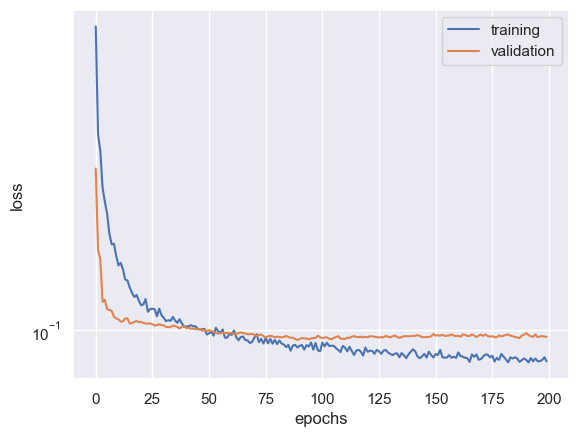

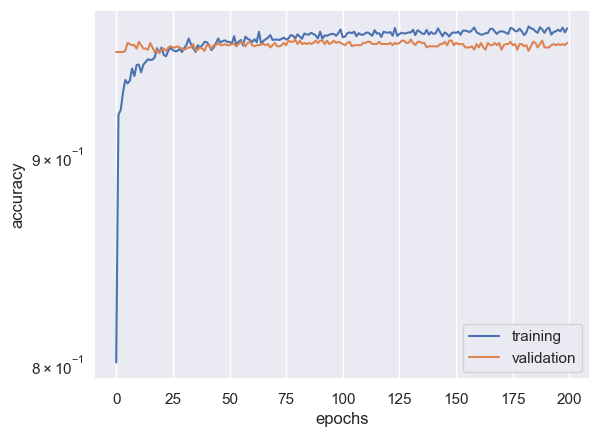

In [14]:
# Visualisation of the training and validation loss evolution over epochs
plt.figure()                    
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.yscale('log')
plt.legend()
plt.savefig('loss.png', bbox_inches='tight')
plt.show()
plt.figure()                    
plt.plot(history.history['accuracy'], label='training')
plt.plot(history.history['val_accuracy'], label='validation')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.yscale('log')
plt.savefig('accuracy.png', bbox_inches='tight')
plt.legend(loc='lower right')
plt.show()

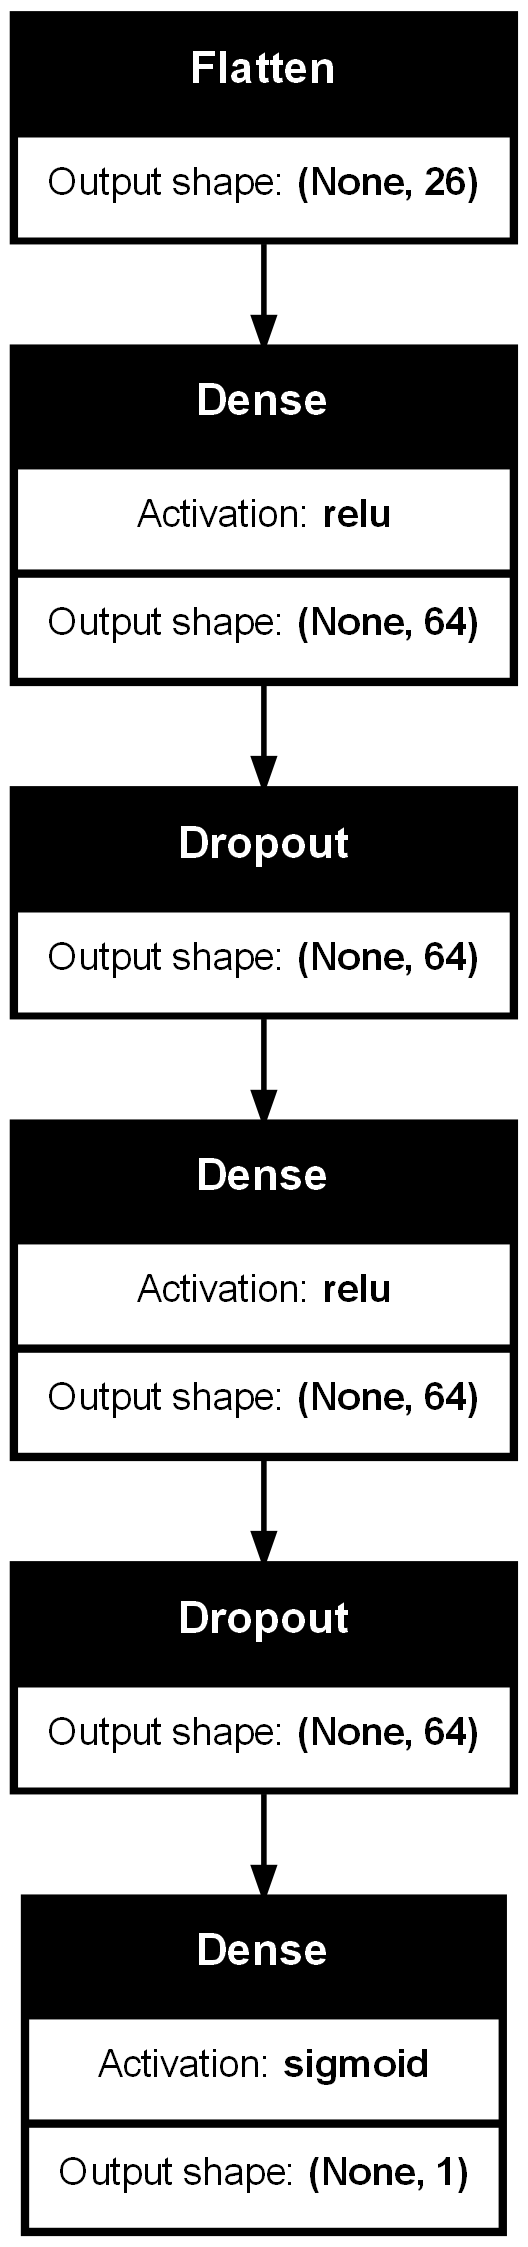

In [36]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_activations=True, expand_nested=True, dpi=200)

A partir des deux graphes ci-dessus, on remarque une évolution usuelle de la perte et la précision d'un tel modèle. La perte descend assez vite, et reste assez stable autour de 0.1 pour la validation et 0.08 pour l'entraînement. On remarque aussi un comportement similaire (mais inverse) de la précision, avec une précision maximale de 97% pour l'entraînement et 96% pour la validation, ceux qui sont des valeurs assez satisfaisantes.

On note que les valeurs de la perte ne sont pas forcément très petite, cela largement dû au fait que nous avons un nombre considérable de joueurs en total (~600 par année), mais seulement environ 24 choisis pour chaque année, et donc nous sommes assez limités dans ce qui concerne la minimisation de la perte (cela peut potentiellement changer avec un jeu de données plus grand, mais pas énormément).

Une fois qu'on a entraîné et évalué le modèle avec les données de validation (***X_test***, ***Y_test***), nous pouvons maintenant vraiment tester notre modèle avec les données de l'année restante (2023) sur notre fichier ***playerdata.csv***. On démarre en réimportant le fichier sur un autre DataFrame, et on sélectionne seulement les données de 2023, en ne gardant que les features avec lesquelles nous avons entraîné le réseau.

In [15]:
# Re-opening the player data dataset (lazy method) for the visualisation of the actual prediction (2023)
test_data_raw = pd.read_csv("playerdata.csv", encoding="utf-8")
test_data = test_data_raw[test_data_raw['Year'] == 2023]

test_data = test_data[init_cols]
test_data

,Age,Games Played,Games Started,MPG,FG,FGA,FG%,3P,3PA,3P%,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,23,55,12,20.7,3.6,7.3,0.485,0.5,2.0,0.269,...,0.702,1.8,4.1,6.0,0.9,0.6,0.5,1.1,1.9,9.2
1,29,42,42,27.0,3.7,6.3,0.597,0.0,0.0,0.000,...,0.364,5.1,6.5,11.5,2.3,0.9,1.1,1.9,2.3,8.6
2,25,75,75,34.6,8.0,14.9,0.540,0.0,0.2,0.083,...,0.806,2.5,6.7,9.2,3.2,1.2,0.8,2.5,2.8,20.4
3,22,59,22,20.5,2.8,6.5,0.427,1.4,3.9,0.355,...,0.812,0.7,1.3,2.1,1.1,0.3,0.3,0.7,1.7,7.9
4,22,77,20,21.8,3.2,6.8,0.470,1.2,3.5,0.353,...,0.750,1.1,3.7,4.8,1.3,0.6,0.6,0.8,1.9,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
534,34,54,9,14.7,2.0,3.7,0.545,0.1,0.6,0.176,...,0.692,1.3,1.8,3.1,1.4,1.0,0.1,0.8,1.6,4.4
535,24,73,73,34.8,8.2,19.0,0.429,2.1,6.3,0.335,...,0.886,0.8,2.2,3.0,10.2,1.1,0.1,4.1,1.4,26.2
536,24,9,0,9.2,1.8,3.0,0.593,0.3,0.8,0.429,...,0.833,0.9,1.7,2.6,0.2,0.2,0.2,0.4,1.8,4.4
537,30,15,2,14.5,2.5,3.9,0.627,0.0,0.1,0.000,...,0.686,1.7,2.6,4.3,0.7,0.2,0.3,0.9,2.2,6.5


Une fois qu'on a sélectionné les données, nous pouvons utiliser la fonction *predict()* pour prédire les joueurs All-Stars de 2023. 

Cette prédiction va nous donner les pourcentages de chaque joueur, et on pose une pourcentage seuil (ad-hoc, ici 65%) pour ce qui nous paraît une valeur sensible pour différencier les joueurs choisis de ceux qui ne sont pas.

In [16]:
# Predicting the All-Stars using the 2023 data
pred = model.predict(test_data)

# Defining an ad-hoc threshold percentage of being chosen, then displaying the players above that percentage (simple preliminary analysis)
filt = np.where(pred >= 6.5e-1)
test_data_raw.iloc[filt[0]]

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


,Unnamed: 0,Year,Name,Position,Age,Team,Games Played,Games Started,MPG,FG,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
10,10,2023,Giannis Antetokounmpo,PF,28,MIL,63,63,32.1,11.2,...,0.645,2.2,9.6,11.8,5.7,0.8,0.8,3.9,3.1,31.1
48,48,2023,Devin Booker,SG,26,PHO,53,53,34.6,9.9,...,0.855,0.9,3.7,4.5,5.5,1.0,0.3,2.7,3.0,27.8
109,109,2023,Anthony Davis,C,29,LAL,56,54,34.0,9.7,...,0.784,3.5,9.1,12.5,2.6,1.1,2.0,2.2,2.6,25.9
124,124,2023,Luka Dončić,PG,23,DAL,66,66,36.2,10.9,...,0.742,0.8,7.8,8.6,8.0,1.4,0.5,3.6,2.5,32.4
142,142,2023,Joel Embiid,C,28,PHI,66,66,34.6,11.0,...,0.857,1.7,8.4,10.2,4.2,1.0,1.7,3.4,3.1,33.1
163,163,2023,Shai Gilgeous-Alexander,PG,24,OKC,68,68,35.5,10.4,...,0.905,0.9,4.0,4.8,5.5,1.6,1.0,2.8,2.8,31.4
238,238,2023,LeBron James,PF,38,LAL,55,54,35.5,11.1,...,0.768,1.2,7.1,8.3,6.8,0.9,0.6,3.2,1.6,28.9
248,248,2023,Nikola Jokić,C,27,DEN,69,69,33.7,9.4,...,0.822,2.4,9.4,11.8,9.8,1.3,0.7,3.6,2.5,24.5
291,291,2023,Damian Lillard,PG,32,POR,58,58,36.3,9.6,...,0.914,0.8,4.0,4.8,7.3,0.9,0.3,3.3,1.9,32.2
345,345,2023,Ja Morant,PG,23,MEM,61,59,31.9,9.3,...,0.748,1.0,4.9,5.9,8.1,1.1,0.3,3.4,1.6,26.2


Nous obtenons ainsi une liste de 15 joueurs en total avec une pourcentage supérieure au seuil, qui n'est pas proche de 24 joueurs attendus, mais cette liste est simplement une visualisation préliminaire du résultat de la prédiction.

En réalité, il y a au moins 12 joueurs choisis par conférence (potentiellement plus, à cause des blessures, remplacements, transferts, etc.), et donc c'est ce qu'on fait dans la suite.

Nous précisons alors la liste des équipes d'une de la conférence de l'Est (le reste étant dans l'Ouest).

In [17]:
# Defining the lists of teams for the eastern conference (remainder of teams defaults to west),
# to be used to display the chosen players for each conference
east = set(['BOS', 'NYK', 'MIL', 'CLE', 'ORL', 'IND', 'PHI', 'MIA', 'CHI', 'ATL', 'BKN', 'TOR', 'CHA', 'WAS', 'DET'])

Nous créons alors un DataFrame contenant les noms des joueurs, leurs équipes, la conférence respective et la probabilité d'être choisi.

In [18]:
# Adding a column containing the conference of the team of each player
disp_data = test_data_raw[['Name', 'Team']]
disp_data = disp_data[test_data_raw['Year'] == 2023]
disp_data['Conference'] = disp_data['Team'].map(lambda x : 'East' if x in east else 'West')

# Adding the results of the prediction on another column
disp_data['Probability'] = pred
disp_data

,Name,Team,Conference,Probability
0,Precious Achiuwa,TOR,East,8.031555e-03
1,Steven Adams,MEM,West,7.051799e-03
2,Bam Adebayo,MIA,East,2.939287e-01
3,Ochai Agbaji,UTA,West,2.004145e-04
4,Santi Aldama,MEM,West,1.977640e-04
...,...,...,...,...
534,Thaddeus Young,TOR,East,2.725049e-09
535,Trae Young,ATL,East,8.389090e-01
536,Omer Yurtseven,MIA,East,1.161775e-07
537,Cody Zeller,MIA,East,2.523775e-06


On sépare maintenant le DataFrame en Est et Ouest, en triant en ordre décroissant de probabilité, on affiche les 25 probabilités les plus hautes, mais on choisit les 12 plus hautes, comme ceux qui seront des All-Stars (comme mentionné précédemment, ce nombre peut facilement varier, mais c'est un minimum de 12).

In [19]:
# Creating a DataFrame for each conference, sorting by prediction values
df_east = disp_data[disp_data['Conference'] == 'East'].sort_values('Probability', ascending=False).reset_index(drop=True)
df_west = disp_data[disp_data['Conference'] == 'West'].sort_values('Probability', ascending=False).reset_index(drop=True)

# Choosing 12 players for each conference, but it can actually be more than 12 in reality (injuries...)
for df in [df_east, df_west]:
    df['Model Prediction'] = df.index.map(lambda x : 'Yes' if x < 12 else 'No')

df_east = df_east[['Name', 'Team', 'Conference', 'Probability', 'Model Prediction']]
df_west = df_west[['Name', 'Team', 'Conference', 'Probability', 'Model Prediction']]

# We display 25 players with the highest probability of being chosen as an All-Star, per conference
summary_conf_size = 25

Nous affichons alors les prédictions des joueurs de chaque conférence.

In [20]:
df_east.head(summary_conf_size).set_index('Name')

,Team,Conference,Probability,Model Prediction
Name,,,,
Giannis Antetokounmpo,MIL,East,0.959071,Yes
Joel Embiid,PHI,East,0.937467,Yes
Trae Young,ATL,East,0.838909,Yes
Jayson Tatum,BOS,East,0.750444,Yes
Jimmy Butler,MIA,East,0.600453,Yes
DeMar DeRozan,CHI,East,0.535099,Yes
Pascal Siakam,TOR,East,0.529766,Yes
Paolo Banchero,ORL,East,0.527540,Yes
Jalen Brunson,NYK,East,0.506514,Yes


In [21]:
df_west.head(summary_conf_size).set_index('Name')

,Team,Conference,Probability,Model Prediction
Name,,,,
Luka Dončić,DAL,West,0.940228,Yes
Shai Gilgeous-Alexander,OKC,West,0.907744,Yes
Ja Morant,MEM,West,0.846172,Yes
Nikola Jokić,DEN,West,0.836281,Yes
Zion Williamson,NOP,West,0.794449,Yes
Anthony Davis,LAL,West,0.705341,Yes
LeBron James,LAL,West,0.699419,Yes
Domantas Sabonis,SAC,West,0.680578,Yes
Damian Lillard,POR,West,0.679479,Yes


Ici c'est la vraie liste des joueurs choisis pour le match All-Stars 2023.

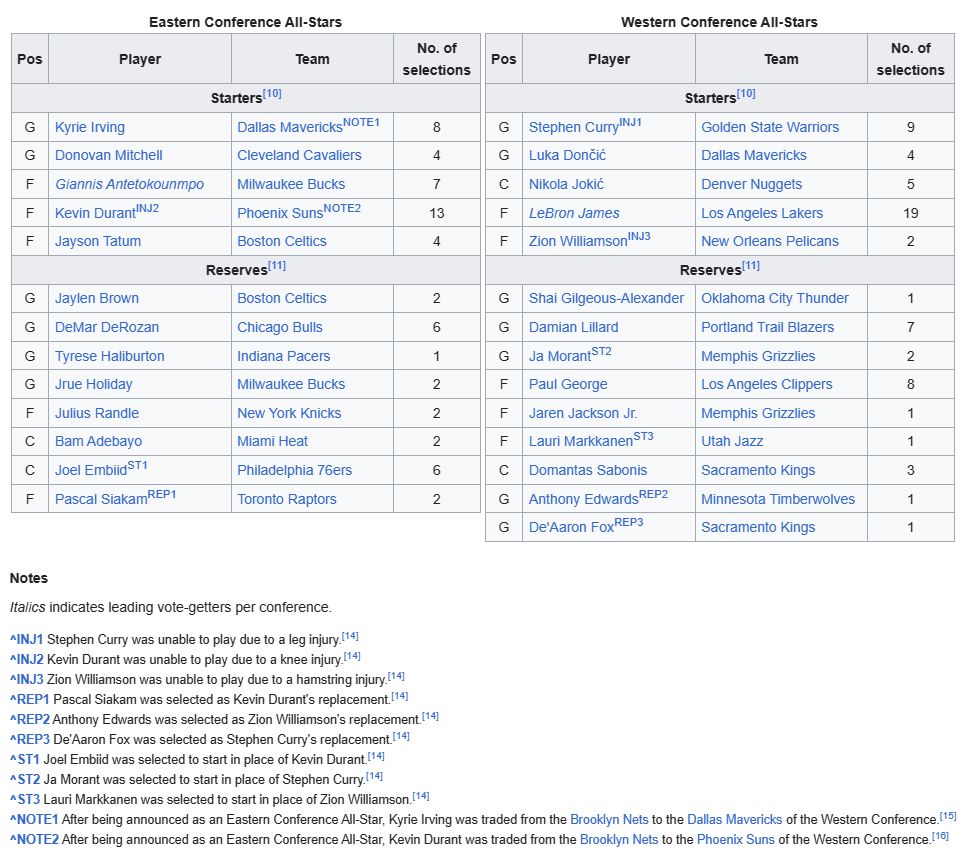

Nous pouvons remarquer ici que la plupart des joueurs ont bien été prédits, mais avec quelques éxceptions notables.

Comme mentionné précédemment, ces exceptions peuvent s'expliquer pas des blessures ou des transferts des joueurs vers des équipes d'une autre conférence, ce qui peut conduire qu'un joueur soit en réalité choisi pour l'autre conférence. A noter aussi que les remplacements des joueurs ne seront pas nécessairement les joueurs suivants dans l'ordre de probabilité, mais même si cela n'est pas une indication très forte (pas un match sérieux), la position du joueur sera un facteur dans le choix des remplacements.

Un autre facteur à considérer, c'est le fait que le match a lieu avant la fin du championnat de l'année en question (Janvier-Février, mais le championnat se termine en avril), et donc les statistiques à considérer ne sont pas nécessairement celles de la saison dans son intégralité.

Nous devons aussi considérer que les joueurs sont choisis par les votes du public, les joueurs et les médias, donc toute prédiction est suscéptible aux choix subjectives, des choix honorifiques, etc.

Dans ce qui concerne l'implémentation du modèle, apart les modifications des jeux de données mentionnés, un autre choix possible serait de faire une normalisation de toutes les statistiques par rapport au 'rythme' moyen du jeu pour chaque année, sachant que la performance des joueurs évolue au cours des années, mais pour notre période de ~10 ans, la différence en termes de performance du modèle serait négligeable. Par contre, si on considère un intervalle de temps plus long en termes d'années, par exemple à partir des années '70-'80, cette normalisation serait bien nécessaire car les différences en termes de rythme et performance sont assez facilement distinguables.

## Modèle Random Forest

Dans cette partie du code, nous allons créer un modèle de forêt aléatoire **(Random Forest)** pour chaque année présente dans notre jeu de données pdata. L'objectif de ces modèles est d'évaluer et de prédire quels joueurs pourraient être considérés comme des All-Stars, en se basant sur les statistiques des années précédentes.

Nous commençons par identifier les années uniques dans le jeu de données à l'aide de la fonction unique(). Cette étape permet de séparer les données année par année afin de créer des forêts aléatoires spécifiques à chaque période.

Pour chaque année identifiée, nous filtrons les données correspondantes. Ensuite, chaque segment de données est utilisé pour entraîner un modèle de forêt aléatoire composé de 100 arbres (paramètre n_estimators=100). Le choix de 100 arbres offre une complexité suffisante pour capter les nuances potentielles des données, ce qui est crucial pour la robustesse et la précision des prédictions.

Nous utilisons le critère de Gini, laissé par défaut dans la fonction RandomForestClassifier, car il a montré de meilleurs résultats lors des entraînements précédents. Ce critère évalue la qualité des divisions dans les arbres et contribue à optimiser la séparation des classes pour une meilleure classification.

Enfin, cette approche segmentée par année nous aide à comprendre comment les critères de sélection des All-Stars peuvent varier au fil du temps, en adaptant le modèle d'année en année pour suivre les évolutions des performances et des tendances dans les données.

In [22]:
cols = ['Games Played','Games Started', 'MPG', 'FG', '3P','3P%', '2P','2P%',
     'FT','FTA', 'TRB', 'AST','STL', 'BLK', 'TOV', 'PTS']
X_tot = pdata[cols]
Y_tot = pdata['AS']

In [23]:
#we gonna create forest off tree for each year
unique_years = pdata['Year'].unique()
models = {}

for year in unique_years:
    #on essaye de filtrer les données pour chaque année
    current_data = pdata[pdata['Year'] == year]
    X_train = current_data[cols]  # Les colonnes des caractéristiques
    y_train = current_data['AS']  # Les réponses
    # Créer et entraîner le modèle
    model = RandomForestClassifier(n_estimators=100,random_state=42)
    model.fit(X_train, y_train)
    #plt.figure(figsize=(4,3), dpi=150)
    etiquettes_resultats = list(map(str, set(y_train)))
    #tree.plot_tree(model,class_names=etiquettes_resultats)
    #plt.show()
    models[year] = model


In [24]:
data = pd.read_csv("playerdata.csv", encoding="utf-8")
testdata_2023 = data[data['Year'] == 2023]

Dans la cellule suivante nous recalibrons les différences nous pourrions avoir sur les nominations des colonnes et les joeurs qui possèdent plusieurs lignes.

In [25]:
testdata_2023 = testdata_2023.rename(columns={'G': 'Games Played', 'GS': 'Games Started', 'MP': 'MPG'})

X_test_2023 = testdata_2023[cols]



Après avoir soigneusement nettoyé notre jeu de données de test pour éliminer tous les problèmes potentiels, nous avons choisi de tester notre modèle sur les données de la dernière année de sélection. Cette décision stratégique s'appuie sur plusieurs observations et réflexions pertinentes :

### Pourquoi ce choix ?

1. **Historique des données** : Notre modèle s'appuie sur plus de dix ans de données historiques, durant lesquelles nous avons observé des changements significatifs dans le rythme de jeu. Ce rythme de jeu, qui influence directement le nombre de points marqués et le pourcentage de réussite des joueurs, a tendance à augmenter au fil des années. Par conséquent, les joueurs marquent davantage de points mais avec des pourcentages de réussite plus faibles.

2. **Pertinence des données récentes** : Nos tests antérieurs ont révélé que les données de l'année précédente (N-1) sont suffisamment représentatives pour prédire les performances de l'année en cours (N). Cette constatation justifie l'utilisation de données récentes, car elles reflètent plus fidèlement les conditions actuelles et les tendances du jeu, permettant ainsi une prédiction plus précise.

3. **Évolution du jeu et adaptation du modèle** : L'évolution constante des stratégies de jeu et des performances athlétiques impose une adaptation régulière de notre modèle pour qu'il reste pertinent. Tester le modèle sur la dernière année de sélection nous permet de valider son adaptabilité et sa réactivité face aux tendances les plus récentes du  du jeu.
---


Nous avons décidé de selectionné contrairement aux reseaux de neuronnes juste le *Random Forest* de l'année N-1 car du fait de l'évolution constant du jeu en NBA et du renouvellement constant des stragégies, les performances des joueurs varient chaque années, et les critères de selections des *All stars* evoluent dans la meme direction.

La sélection de l'année la plus récente pour le test de notre modèle est motivée par la nécessité de comprendre comment les changements récents dans le rythme et les stratégies de jeu affectent les performances des joueurs. Cela nous aide à optimiser notre modèle pour qu'il soit non seulement actuel mais aussi prédictif, avec une capacité à s'adapter aux évolutions futures du jeu.

In [26]:

# Choix du modèle pour la prédiction
# Supposons que vous souhaitez utiliser le modèle le plus récent, ici le modèle de l'année la plus élevée disponible
latest_year = max(models.keys())
selected_model = models[latest_year]

Nous utilisons la fonction **predict()** pour estimer les chances de chaque joueur d'être sélectionné comme All-Star. Cette fonction génère une prédiction binaire où 0 indique qu'un joueur n'est pas considéré pour le titre d'All-Star et 1 suggère qu'il pourrait l'être. Ces prédictions sont ensuite intégrées au jeu de données testdata_2023 pour une visualisation et une analyse plus simple.

In [27]:
# Prédiction en utilisant le modèle sélectionné
predictions_2023 = selected_model.predict(X_test_2023)

# Ajout des prédictions à testdata_2024 pour l'affichage ou l'analyse ultérieure
testdata_2023['Predicted AS'] = predictions_2023

print(testdata_2023[['Name', 'Predicted AS']])
all_stars = testdata_2023[testdata_2023['Predicted AS'] == 1]
print(all_stars[['Name', 'Predicted AS']])
print("Nous trouvons un nombre de ",len(all_stars)," all stars prédis par notre modèle pour l'année 2023")

                 Name  Predicted AS
0    Precious Achiuwa           0.0
1        Steven Adams           0.0
2         Bam Adebayo           1.0
3        Ochai Agbaji           0.0
4        Santi Aldama           0.0
..                ...           ...
534    Thaddeus Young           0.0
535        Trae Young           1.0
536    Omer Yurtseven           0.0
537       Cody Zeller           0.0
538       Ivica Zubac           0.0

[539 rows x 2 columns]
                        Name  Predicted AS
2                Bam Adebayo           1.0
10     Giannis Antetokounmpo           1.0
48              Devin Booker           1.0
63              Jaylen Brown           1.0
116            DeMar DeRozan           1.0
124              Luka Dončić           1.0
139          Anthony Edwards           1.0
142              Joel Embiid           1.0
152             De'Aaron Fox           1.0
160              Paul George           1.0
163  Shai Gilgeous-Alexander           1.0
238             LeBron James

Comme le montre la sortie ci-dessus, notre modèle a prédit 21 joueurs comme potentiels All-Stars pour l'année en cours. Cette prédiction est particulièrement significative étant donné que la liste officielle des All-Stars comprend généralement 24 joueurs, répartis à parts égales entre les deux conférences de la ligue (12 joueurs par conférence). Ainsi, notre modèle se rapproche remarquablement de la composition réelle, capturant avec précision les tendances et les performances des joueurs qui sont susceptibles d'être reconnus à ce niveau d'excellence.

Nous procédons ensuite à un affinement de notre analyse en séparant les joueurs en fonction de leur appartenance à une conférence. Pour cette présentation, nous nous focalisons d'abord sur la liste des joueurs de la conférence de l'Est. 

In [28]:
# Supposons que testdata_2023 ait une colonne 'Team'
# On ajoute une colonne pour la conférnece de l'équipe d'appartenance du joueur
testdata_2023['Conference'] = testdata_2023['Team'].apply(lambda x: 'East' if x in east else 'West')

# Prédiction pour les joueurs All-Star
all_stars = testdata_2023[testdata_2023['Predicted AS'] == 1]

# Trier les joueurs All-Star par conférence
east_all_stars = all_stars[all_stars['Conference'] == 'East']
west_all_stars = all_stars[all_stars['Conference'] == 'West']

print("All-Stars qui appartiennent à la Conférence Est:")
print(east_all_stars[['Name', 'Team', 'Predicted AS', 'Conference']])

print("\nAll-Stars qui appartiennent à la Conférence Ouest:")
print(west_all_stars[['Name', 'Team', 'Predicted AS', 'Conference']])


All-Stars qui appartiennent à la Conférence Est:
                      Name Team  Predicted AS Conference
2              Bam Adebayo  MIA           1.0       East
10   Giannis Antetokounmpo  MIL           1.0       East
63            Jaylen Brown  BOS           1.0       East
116          DeMar DeRozan  CHI           1.0       East
142            Joel Embiid  PHI           1.0       East
337       Donovan Mitchell  CLE           1.0       East
404          Julius Randle  NYK           1.0       East
441          Pascal Siakam  TOR           1.0       East
464           Jayson Tatum  BOS           1.0       East
535             Trae Young  ATL           1.0       East

All-Stars qui appartiennent à la Conférence Ouest:
                        Name Team  Predicted AS Conference
48              Devin Booker  PHO           1.0       West
124              Luka Dončić  DAL           1.0       West
139          Anthony Edwards  MIN           1.0       West
152             De'Aaron Fox  SAC   

Nous pouvons constater que notre modele a reussit a prédire plus de potentiel all star du coté Ouest que du coté Est.

Dans la suite nous allons afficher la liste des **vrais ALL STAR 2023** afin de voir l'efficacité de notre modele.

In [29]:
# Liste hypothétique des vrais All-Stars
true_all_stars = [
    "Kyrie Irving", "Donovan Mitchell", "Giannis Antetokounmpo", "Kevin Durant", "Jayson Tatum",
    "Jaylen Brown", "DeMar DeRozan", "Tyrese Haliburton", "Jrue Holiday", "Julius Randle", 
    "Bam Adebayo", "Joel Embiid", "Pascal Siakam", "Stephen Curry", "Luka Dončić", 
    "Nikola Jokić", "LeBron James", "Zion Williamson", "Shai Gilgeous-Alexander", 
    "Damian Lillard", "Ja Morant", "Paul George", "Jaren Jackson Jr.", "Lauri Markkanen", 
    "Domantas Sabonis", "Anthony Edwards", "De'Aaron Fox"
]

# Créer un DataFrame pour les vrais All-Stars
true_all_stars_df = pd.DataFrame(true_all_stars, columns=['Name'])
true_all_stars_df['Is_True_All_Star'] = True

# Supposons que testdata_2023 a déjà les prédictions
# Ajouter la colonne 'Is_Predicted_All_Star'
testdata_2023['Is_Predicted_All_Star'] = testdata_2023['Predicted AS'] == 1

# Fusionner les données de test avec les vrais All-Stars
results = testdata_2023.merge(true_all_stars_df, on='Name', how='left')
results['Is_True_All_Star'].fillna(False, inplace=True)
''# Filtrer pour obtenir uniquement les vrais All-Stars
true_all_stars_results = results[results['Is_True_All_Star'] == True]

# Ajouter une colonne pour vérifier si la prédiction est correcte
true_all_stars_results['Prediction_Correct'] = true_all_stars_results['Is_Predicted_All_Star']

# Sélectionner les colonnes à afficher
affichage_finale = true_all_stars_results[['Name', 'Team', 'Is_Predicted_All_Star', 'Prediction_Correct']]
print(affichage_finale)


                        Name Team  Is_Predicted_All_Star  Prediction_Correct
2                Bam Adebayo  MIA                   True                True
10     Giannis Antetokounmpo  MIL                   True                True
63              Jaylen Brown  BOS                   True                True
107            Stephen Curry  GSW                  False               False
116            DeMar DeRozan  CHI                   True                True
124              Luka Dončić  DAL                   True                True
136             Kevin Durant  PHO                  False               False
139          Anthony Edwards  MIN                   True                True
142              Joel Embiid  PHI                   True                True
152             De'Aaron Fox  SAC                   True                True
160              Paul George  LAC                   True                True
163  Shai Gilgeous-Alexander  OKC                   True                True

C:\Users\livio\AppData\Local\Temp\ipykernel_10688\2116356345.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  true_all_stars_results['Prediction_Correct'] = true_all_stars_results['Is_Predicted_All_Star']


Nous remarquons ici que, pour le modèle Random Forest, on revient à un résultat similaire en termes de précision (Les modèles étant différents, ils donnent des formats de résultats différents en sortie) à ce qu'on a obtenu pour le réseau de neurones.

Les facteurs qui jouent un rôle sur cette précision sont bien sûr les mêmes que ceux mentionnés précédemment.